# 03 – Analysis and Visualization


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

This notebook presents a systematic analysis of all handshake experiments executed in the Key Exchange (KEX) performance evaluation framework.
It builds upon the parsed data from `02_parsing_and_exploration.ipynb`, consolidating runtime metrics, resource usage, and experiment metadata.
The data includes multiple experiments across three KEX modes (`classic`, `hybrid`, `pqc`) and two execution environments (`docker`, `native`), under various network profiles.


## 1. Introduction

### Objectives

The main objectives of this analysis are:

- Determine which key exchange variant performs best in terms of handshake duration and resource usage.
- Assess the impact of constrained network profiles on handshake performance taking into account the key exchange algorithm
- Compare the behavior of Docker-based versus native execution environments.
- Analyze the CPU and RAM usage across different modes and setups.
- Examine handshake stability under various simulated conditions.


### Research Questions

- How does a hybrid key exchange approach impact handshake efficiency under varying network conditions?
- What performance trade-offs exist between classical, hybrid, and post-quantum key exchange modes?
- Is Docker-based execution significantly different in terms of timing and system resource usage compared to native execution?
- How stable and robust are the different key exchange variants when deployed under constrained network profiles?

## 2. Methodology

This section outlines the experimental setup, including the execution environments, the applied network profiles, and the measurement approach.

Experiments were executed using both Docker-based containers and native Python processes. Simulated network conditions were applied using `tc netem` in the Docker setup to reflect realistic latency, packet loss, and bandwidth constraints.

### 2.1 Execution Environments

Two environments were used to run the experiments:

- **Docker**: Client and server were executed in isolated containers connected via a custom bridge network. Network manipulation using `tc netem` was applied directly inside the server container.
- **Native**: Client and server were executed as native Python processes on the host system without additional containerization or artificial network constraints.

Note: Only `experiment_01` was executed in both environments and can therefore be used for direct Docker vs. Native comparison.


### 2.2 Network Profiles

To simulate constrained or realistic environments, six network profiles were defined and applied to the Docker-based experiments via `tc netem`. These profiles emulate common real-world scenarios such as mobile networks, WiFi, and satellite communication.

Each profile defines parameters for:

- **Delay** (one-way latency per packet)
- **Packet loss** (random drop probability)
- **Rate limiting** (maximum bandwidth)
- **Burst and latency buffer** (for TBF shaping)

The profiles were applied to `experiment_02` through `experiment_06`. The native setup did not include artificial constraints.


| Experiment ID | Profile Name         | Delay | Packet Loss | Bandwidth | Burst  | Latency Buffer |
|---------------|----------------------|--------|--------------|-----------|--------|----------------|
| experiment_01 | None (baseline)      | —      | —            | —         | —      | —              |
| experiment_02 | netem_mobile         | 150ms  | 3%           | 700kbit   | 32kbit | 500ms          |
| experiment_03 | netem_lan            | 200ms  | 0%           | —         | —      | —              |
| experiment_04 | netem_package_loss   | 50ms   | 10%          | —         | —      | —              |
| experiment_05 | netem_good_wlan      | 30ms   | 0.5%         | 5mbit     | 64kbit | 200ms          |
| experiment_06 | netem_satelite       | 30ms   | 0.5%         | 5mbit     | 64kbit | 200ms          |

### 2.3 Hardware

All experiments were conducted locally on the following hardware:

- **Device**: MacBook Pro (Apple Silicon)
- **Chip**: Apple M4 Pro
- **Memory**: 24GB Unified Memory
- **CPU**: 12-core
- **GPU**: 16-core

Both Docker and native processes were executed on the same machine under low system load to ensure reproducibility and consistency.


## 3. Client vs. Server Duration Comparison

This section investigates the differences between the handshake duration measured by the client and the server.

Since both sides log their own timing independently, analyzing the gap between these values helps understand whether:

- network latency is accurately reflected in the measurements,
- one side systematically under- or overestimates the handshake duration,
- client-side and server-side processing times differ by key exchange mode.

In [8]:
#Load dataframe from csv (created in previous notebook)
df_all = pd.read_csv("../data/all_measurements.csv")

In [9]:
# Filter only relevant columns for merging
client_df = df_all[df_all["side"] == "client"][["experiment", "setup", "mode", "duration_sec"]].copy()
client_df = client_df.rename(columns={"duration_sec": "duration_client"})

server_df = df_all[df_all["side"] == "server"][["experiment", "setup", "mode", "duration_sec"]].copy()
server_df = server_df.rename(columns={"duration_sec": "duration_server"})

In [10]:
# Merge client and server logs row-wise by experiment/setup/mode
df_merged = pd.merge(client_df, server_df, on=["experiment", "setup", "mode"])

# Calculate absolute and relative difference
df_merged["abs_diff"] = (df_merged["duration_client"] - df_merged["duration_server"]).abs()
df_merged["rel_diff"] = df_merged["abs_diff"] / df_merged[["duration_client", "duration_server"]].max(axis=1)

We calculate both the absolute and relative difference in handshake duration between client and server, grouped by mode and experiment.

This helps identify whether one side consistently reports higher durations and whether the gap depends on the network profile or execution mode.


In [11]:
df_diff_summary = (
    df_merged
    .groupby(["setup", "experiment", "mode"])[["duration_client", "duration_server", "abs_diff", "rel_diff"]]
    .median()
    .reset_index()
)

df_diff_summary

,setup,experiment,mode,duration_client,duration_server,abs_diff,rel_diff
0,docker,experiment_01,classic,0.000230,0.000113,0.000107,0.500000
1,docker,experiment_01,hybrid,0.000286,0.000244,0.000046,0.160808
2,docker,experiment_01,pqc,0.000205,0.000121,0.000091,0.423402
3,docker,experiment_02,classic,0.307870,0.154496,0.153761,0.499354
4,docker,experiment_02,hybrid,0.308751,0.155490,0.153503,0.497283
5,docker,experiment_02,pqc,0.308323,0.154585,0.153967,0.499370
6,docker,experiment_03,classic,0.408155,0.204739,0.203591,0.498703
7,docker,experiment_03,hybrid,0.410920,0.206668,0.204335,0.497467
8,docker,experiment_03,pqc,0.408299,0.204730,0.203722,0.498793
9,docker,experiment_04,classic,0.108011,0.054715,0.054384,0.503523


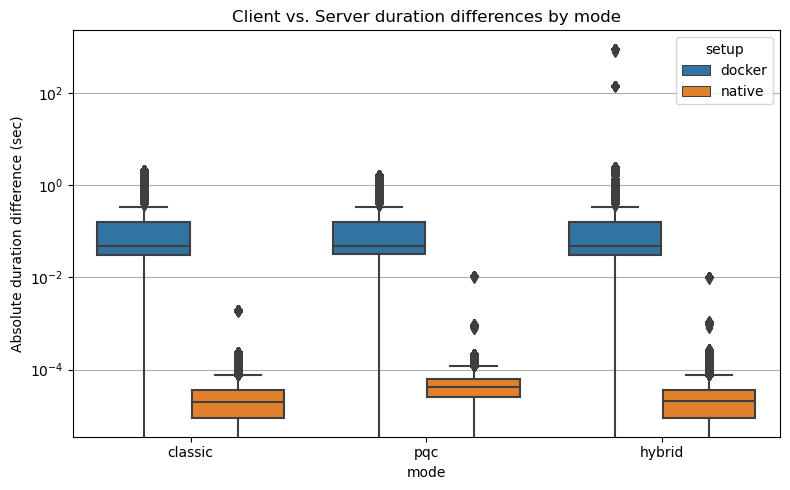

In [13]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_merged,
    x="mode",
    y="abs_diff",
    hue="setup"
)
plt.ylabel("Absolute duration difference (sec)")
plt.title("Client vs. Server duration differences by mode")
plt.grid(axis='y')
plt.yscale("log")
plt.tight_layout()
plt.show()

### 3.4 Interpretation: Client vs. Server Duration Differences

The plot above shows the absolute difference in handshake duration as measured independently by the client and the server, grouped by key exchange mode and execution environment. The Y-axis is logarithmic to reveal both small and large differences.

#### Key Observations:

- **Docker setup consistently shows higher client-server discrepancies** compared to the native environment.
- The **native setup reports differences in the sub-millisecond range**, typically between `10^-4` and `10^-3` seconds.
- In contrast, **Docker-based runs often reach 10–100 milliseconds**, with some extreme outliers in the 100+ second range (likely due to outliers, network queuing, or logging delays).
- Across all modes (`classic`, `pqc`, `hybrid`), the **discrepancy pattern is consistent**: Docker > Native.

#### Explanation:

This discrepancy is likely due to the fact that **network emulation (`netem`) was applied only on the server container**, introducing artificial delay, bandwidth throttling, and packet loss:

- Since the **client measures round-trip time**, any server-side delay is included in the client's `duration_sec`.
- The **server, however, logs only its local processing time** and is unaware of any additional delay imposed on its own outbound or inbound traffic.
- This asymmetry explains why **client durations are often significantly higher** in Docker-based experiments.

#### Conclusion:

While the measurements from client and server are both valuable, **client-side durations provide a more comprehensive picture** in this setup, especially when `netem` is active. For comparative analysis and visualization, we therefore focus on client-side metrics unless explicitly noted.


## 4. Docker vs. Native Comparison


This section compares the performance and resource usage of the Docker-based and native execution environments.

Only `experiment_01` was executed in both setups under identical conditions (no artificial network constraints) and can therefore be used for direct comparison.

Metrics such as handshake duration, CPU usage, and RAM usage will be evaluated per key exchange mode (`classic`, `hybrid`, `pqc`) and execution environment.


The analysis aims to answer the following questions:

- Is there a measurable performance difference between Docker and native execution?
- Does Docker introduce additional CPU or memory overhead?
- Are certain key exchange modes more affected by the environment than others?


In [1]:
# Filter the full dataset for experiment_01 only
df_exp01 = df_all[df_all["experiment"] == "experiment_01"]

# Preview to confirm
df_exp01.groupby(["setup", "mode", "side"]).size().unstack()

side            client  server
setup  mode                   
docker classic    1000    1000
       hybrid     1000    1000
       pqc        1000    1000
native classic    1000    1000
       hybrid     1000    1000
       pqc        1000    1000

### 4.1 Mean Handshake Duration by Mode and Setup

We compute the mean handshake duration per key exchange mode and compare the Docker and native environments.


In [3]:
df_duration = (
    df_exp01[df_exp01["side"] == "client"]
    .groupby(["setup", "mode"])["duration_sec"]
    .agg(["mean", "median", "std"])
    .reset_index()
)

df_duration


,setup,mode,mean,median,std
0,docker,classic,0.000229,0.000230,0.000117
1,docker,hybrid,0.000300,0.000286,0.000073
2,docker,pqc,0.000216,0.000205,0.000082
3,native,classic,0.000258,0.000249,0.000067
4,native,hybrid,0.000330,0.000317,0.000324
5,native,pqc,0.000115,0.000098,0.000333


### 4.2 Visual Comparison – Handshake Duration

The following bar plot shows the mean duration per key exchange mode, grouped by execution environment.


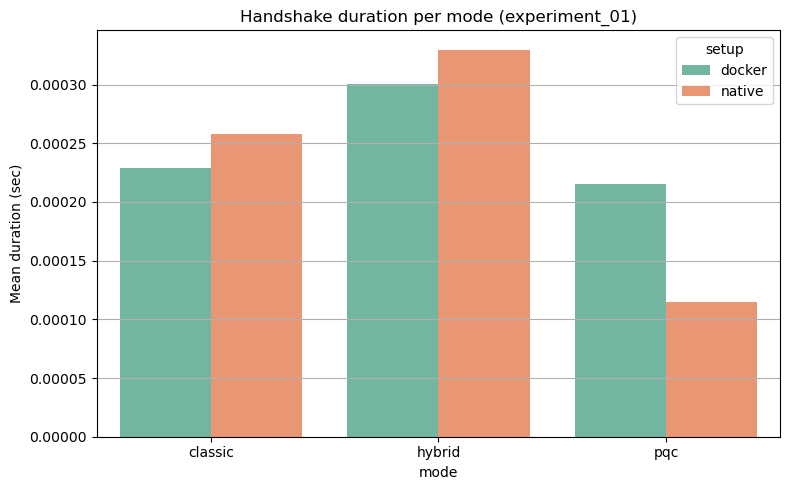

In [6]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_duration,
    x="mode",
    y="mean",
    hue="setup",
    palette="Set2"
)
plt.ylabel("Mean duration (sec)")
plt.title("Handshake duration per mode (experiment_01)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()